In [116]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
import random
import torch
from torch import nn
import torch.optim as optim

In [117]:
def sinusoidal(sequence_length):
  t = np.arange(sequence_length)
  amplitude = 1
  frequency = 0.1
  mean_drift = 0.01
  c = 0
  noise_factor = 0.1
  noise = noise_factor * np.random.randn(sequence_length)
  input_data = amplitude * np.sin(frequency * t + c) + mean_drift*t + noise
  return input_data

In [118]:
class NeuroModulatoryLeakyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, neuromodulator_size):
      super(NeuroModulatoryLeakyRNN, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.alpha = nn.Parameter(torch.tensor(0.5))

      self.neuromodulator = nn.Linear(neuromodulator_size, hidden_size)

      self.input_h = nn.Linear(input_size, hidden_size)
      self.h_h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
      batch_size = input_shape[1]
      return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
      h_new = torch.relu(torch.tanh(self.input_h(input) + self.h_h(hidden)))
      h_new = hidden * (1 - self.alpha) + h_new * self.alpha
      return h_new

    def forward(self, input, hidden=None):
      if hidden is None:
        hidden = self.init_hidden(input.shape).to(input.device)

      output = []
      steps = range(input.size(0))
      for i in steps:
        hidden = self.recurrence(input[i], hidden)
        output.append(hidden)

      output = torch.stack(output, dim=0)
      return output, hidden

class LeakyRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, neuromodulator_size):
    super(LeakyRNN, self).__init__()

    self.rnn = NeuroModulatoryLeakyRNN(input_size, hidden_size, neuromodulator_size)

    # Output layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    rnn_output, _ = self.rnn(x)
    output = self.fc(rnn_output)
    return output, rnn_output



In [119]:
# Hyperparameters
input_size = 1
hidden_size = 100
output_size = 1
batch_size = 16
neuromodulator_size = 1
sequence_length = 100
num_epochs = 1000
learning_rate = 0.001
neuromodulator_learning_rate = 0.01

# Create Leaky RNN with neuroModulator
model = LeakyRNN(input_size, hidden_size, output_size, neuromodulator_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
neuromodulator_optimizer = optim.SGD(model.rnn.parameters(), lr=neuromodulator_learning_rate)

In [120]:
train_dataset = sinusoidal(sequence_length)
test_dataset = sinusoidal(sequence_length) # Generate synthetic test data

# Convert train data to PyTorch tensor
train_inputs = torch.tensor(train_dataset[:-1], dtype=torch.float32).view(1, -1, 1)
train_targets = torch.tensor(train_dataset[1:], dtype=torch.float32).view(1, -1, 1)

# Convert test data to PyTorch tensor
test_inputs = torch.tensor(test_dataset[:-1], dtype=torch.float32).view(1, -1, 1)
test_targets = torch.tensor(test_dataset[1:], dtype=torch.float32).view(1, -1, 1)

In [121]:
# Training process

def train(model, criterion, optimizer, neuromodulator_optimizer, train_inputs, train_targets, epochs):
  for epoch in range(epochs):
    optimizer.zero_grad()
    neuromodulator_optimizer.zero_grad()

    outputs, _ = model(train_inputs)
    loss = criterion(outputs, train_targets)

    loss.backward()
    optimizer.step()
    neuromodulator_optimizer.step()

    if epoch % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [122]:
def evaluation(model, test_inputs):
  model.eval()
  with torch.no_grad():
        outputs, _ = model(test_inputs)
  return outputs.numpy()

In [123]:
train(model, criterion, optimizer, neuromodulator_optimizer, train_inputs, train_targets, num_epochs)

test_outputs = evaluation(model, test_inputs)

Epoch [1/1000], Loss: 0.9232
Epoch [101/1000], Loss: 0.1669
Epoch [201/1000], Loss: 0.0614
Epoch [301/1000], Loss: 0.0362
Epoch [401/1000], Loss: 0.0320
Epoch [501/1000], Loss: 0.0308
Epoch [601/1000], Loss: 0.0300
Epoch [701/1000], Loss: 0.0294
Epoch [801/1000], Loss: 0.0289
Epoch [901/1000], Loss: 0.0285


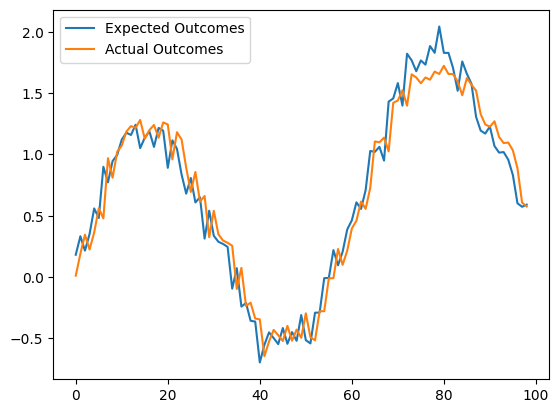

In [124]:
plt.plot(test_dataset[1:], label='Expected Outcomes')
plt.plot(test_outputs[0], label='Actual Outcomes')
plt.legend()
plt.show()
